### **ECON 323 FINAL PROJECT**

### **PARLIAMENTARY PARTICIPATION AND ELECTORAL SUCCESS**

##### INTRODUCTION

In this project, we aim to create a visualization notebook based on a ECON 490 paper. The paper explores the impact of parliamentary participation on electoral success particularly in the Canadian House of Commons. 

In this case, parliamentary participation is measured by participation in question period and statements made in the House of Commons and the private member bills introduced by the Member of Parliament. Electoral success is measured by whether or not the Member of Parliament was reelected in the next federal elections.

For this project, we will create a visualization notebook that focuses on:
- visually summarizing the variables 
- exploring relationships between the independent and dependent variables 

##### LOADING PACKAGES

We start by loading all the necessary packages:

In [51]:
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import matplotlib.colors as colors

##### INTRODUCING THE DATA 

##### *Reading the Data*

We will first load in the data from csv files and rename columns so that the two dataframes can be concatenated.

The data in the csv files has been compiled from several sources:
- Elections Canada for reelection and riding information
- OurCommons website for information on Private Member's Bills, statements made and Cabinet ministers
- SQL Database from the openparliament.com website for gender, party and politician name
- Conservative.ca website for information on Shadow Cabinet
- Age and years in House of Commons from Parl.ca website 

The timeframe for this data is from the 2015 federal elections to the 2021 federal elections i.e. the information considers all parliamentary activity from the 42nd and 43rd Parliament.

In [13]:
# reading in csv data 
results15 = pd.read_csv("DATA/2015Results.csv")
results19 = pd.read_csv("DATA/2019Results.csv")

In [14]:
# renaming columns so that dataframes can be concatenated correctly 
Results15 = results15.rename(columns = {"RidingID":"Riding ID", "ranfor43":"RanForNE", "reelected43":"Reelected", "DOB1":"DOB", "YearsServedAtTimeOfElection":"YearsInHOC"})
Results19 = results19.rename(columns = {"Election":"Parliament", "ranfor44":"RanForNE", "reelected44":"Reelected", "StatementsByMembers":"Statements", "YearsServedAtElection":"YearsInHOC"})

In [15]:
# concatenating dataframes
Results_Full = pd.concat([Results15, Results19], ignore_index=True)
Results_Full.head()
# combining 2015 and 2019 datasets leds to MPs showing up twice -- doesn't matter for analysis because each row is just one observation - person itself doesnt matter

,Name,Party,Parliament,Politician ID,Riding ID,Province,Gender,RanForNE,Reelected,QuestionPeriod,PvtMemBills,Statements,Backbencher,DOB,AgeOnElectionDay,YearsInHOC
0,Dean Allison,Conservative Party of Canada,42,5,35068,ON,M,Yes,Yes,42,0,19,0,1965-02-18,54.0,15.323288
1,Rona Ambrose,Conservative Party of Canada,42,6,48033,AB,F,No,.,457,1,3,0,1969-03-15,50.0,15.323288
2,David Anderson,Conservative Party of Canada,42,9,47002,SK,M,No,.,53,1,20,0,1957-08-15,62.0,18.909589
3,Charlie Angus,New Democratic Party,42,11,35107,ON,M,Yes,Yes,168,0,15,1,1962-11-14,56.0,15.323288
4,Larry Bagnell,Liberal Party of Canada,42,15,60001,YT,M,Yes,Yes,11,1,15,1,1949-12-19,69.0,16.350685


##### *Creating Dummy Variables*

Next, we create dummy variables for the following categorical variables:
- Gender
- RanForNE (i.e. whether or not the MP ran for the next federal election)
- ReelectionNE (i.e. whether or not the MP was reelected in the next federal election)
- Party (i.e. whether or not a MP belong to the Conservative Party, Liberal Party or the New Democratic Party)

In [16]:
# creating a dataframe with columns that need to be converted to dummy variables
Results_Dummy = pd.DataFrame(data=Results_Full, columns=['Gender', 'RanForNE', 'Reelected', 'Party'])

# creating dummy variables for each column of the above dataset
Dummies = pd.get_dummies(Results_Dummy)
Dummies.head()

,Gender_F,Gender_M,RanForNE_No,RanForNE_Yes,Reelected_.,Reelected_No,Reelected_Yes,Party_Bloc Québécois,Party_Conservative Party of Canada,Party_Green Party of Canada,Party_Independent,Party_Liberal Party of Canada,Party_New Democratic Party
0,0,1,0,1,0,0,1,0,1,0,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0,0
2,0,1,1,0,1,0,0,0,1,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,1
4,0,1,0,1,0,0,1,0,0,0,0,1,0


Then, we add the previously created dummy variables to the original dataframe. Just to clean up, we rename some columns for clarity and drop unnecessary columns.

In [17]:
# adding newly created dummy variables to the original dataframe
Results = pd.concat([Results_Full, Dummies], axis = 1)

# removing unnecessary columns
Results = Results.drop(columns=['Gender', 'RanForNE', 'Reelected', 'Party', 'DOB', 'Gender_M', 'RanForNE_No', 'Reelected_.', 'Reelected_No', 'Party_Bloc Québécois', 'Party_Green Party of Canada', 'Party_Independent'])

# renaming columns for better understanding
Results = Results.rename(columns = {"Gender_F":"Gender", "RanForNE_Yes":"RanForNE", "Reelected_Yes":"Reelected", "Party_Conservative Party of Canada":"ConservativeMem", "Party_Liberal Party of Canada":"LiberalMem", "Party_New Democratic Party":"NDPMem"})

##### *Manipulating the Data*

- create a histogram here? to explain questionlog 

In [55]:
# creating a log of the QuestionPeriod variable
Results['QuestionsLog'] = np.log10(Results['QuestionPeriod'])
Results = Results.loc[Results['QuestionPeriod'] >= 1]
Results

/Users/anahat/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Name,Parliament,Politician ID,Riding ID,Province,QuestionPeriod,PvtMemBills,Statements,Backbencher,AgeOnElectionDay,YearsInHOC,Gender,RanForNE,Reelected,ConservativeMem,LiberalMem,NDPMem,QuestionsLog
0,Dean Allison,42,5,35068,ON,42,0,19,0,54.0,15.323288,0,1,1,1,0,0,1.623249
1,Rona Ambrose,42,6,48033,AB,457,1,3,0,50.0,15.323288,1,0,0,1,0,0,2.659916
2,David Anderson,42,9,47002,SK,53,1,20,0,62.0,18.909589,0,0,0,1,0,0,1.724276
3,Charlie Angus,42,11,35107,ON,168,0,15,1,56.0,15.323288,0,1,1,0,0,1,2.225309
4,Larry Bagnell,42,15,60001,YT,11,1,15,1,69.0,16.350685,0,1,1,0,1,0,1.041393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,Maninder Sidhu,43,12210,35009,ON,5,0,3,1,37.0,1.917808,0,1,1,0,1,0,0.698970
692,Nelly Shin,43,12222,59023,BC,13,0,6,0,50.0,1.917808,1,1,0,1,0,0,1.113943
693,Rob Morrison,43,12228,59015,BC,10,0,4,0,65.0,1.917808,0,1,1,1,0,0,1.000000
694,Marci Ien,43,12231,35108,ON,4,0,2,1,52.0,0.901370,1,1,1,0,1,0,0.602060


Now just summarize the data - where we are at so far basically

In [36]:
PlottingDF = pd.DataFrame(data=Results, columns=['Name', 'Parliament', 'Riding ID', 'RanForNE', 'Reelected'])
PlottingDF

def f(row):
    if row['RanForNE'] == row['Reelected'] == 1:
        val = 1
    elif row['RanForNE'] == 0:
        val = 2
    else:
        val = 3
    return val

PlottingDF['Outcome'] = PlottingDF.apply(f, axis=1)
PlottingDF

# 1 IF Ran for REELECTION and WON
# 2 IF DID NOT RUN FOR REEELCTION
# 3 IF Ran for REELECTION and LOST

Plotting19 = PlottingDF.loc[PlottingDF['Parliament'] == 42] # results for 2019 
Plotting21 = PlottingDF.loc[PlottingDF['Parliament'] == 43] # results for 2021

,Name,Parliament,Riding ID,RanForNE,Reelected,Outcome
0,Dean Allison,42,35068,1,1,1
1,Rona Ambrose,42,48033,0,0,2
2,David Anderson,42,47002,0,0,2
3,Charlie Angus,42,35107,1,1,1
4,Larry Bagnell,42,60001,1,1,1
...,...,...,...,...,...,...
336,Nathaniel Erskine-Smith,42,35007,1,1,1
337,Neil Ellis,42,35006,1,1,1
338,Raj Grewal,42,35009,0,0,2
339,Ramesh Sangha,42,35008,1,1,1


In [43]:
map2019 = pd.merge(Ridings, Plotting19, on = 'Riding ID')
map2019
map2021 = pd.merge(Ridings, Plotting21, on = 'Riding ID')
map2021


,OBJECTID,Riding ID,ED_NAMEE,ED_NAMEF,SHAPE_Leng,SHAPE_Area,REPORDER,geometry,Name,Parliament,RanForNE,Reelected,Outcome
0,1,24065,Marc-Aurèle-Fortin,Marc-Aurèle-Fortin,3.457259e+04,5.757633e+07,2013,"POLYGON ((7617177.237 1251302.749, 7617204.257...",Yves Robillard,43,1,1,1
1,2,24066,Saint-Hyacinthe--Bagot,Saint-Hyacinthe--Bagot,2.682552e+05,1.948976e+09,2013,"POLYGON ((7676021.069 1298980.889, 7677378.700...",Simon-Pierre Savard-Tremblay,43,1,1,1
2,3,24067,Saint-Jean,Saint-Jean,1.967537e+05,7.342893e+08,2013,"POLYGON ((7676482.217 1243373.957, 7676493.511...",Christine Normandin,43,1,1,1
3,4,24069,Saint-Léonard--Saint-Michel,Saint-Léonard--Saint-Michel,2.058736e+04,2.086278e+07,2013,"POLYGON ((7625672.963 1255638.760, 7626411.120...",Patricia Lattanzio,43,1,1,1
4,5,24070,Saint-Maurice--Champlain,Saint-Maurice--Champlain,1.180212e+06,3.896728e+10,2013,"POLYGON ((7459301.751 1597664.723, 7459403.646...",François-Philippe Champagne,43,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,344,35107,Timmins--James Bay,Timmins--Baie James,3.515773e+06,2.516392e+11,2013,"POLYGON ((6527676.451 2190963.086, 6527684.440...",Charlie Angus,43,1,1,1
363,345,35108,Toronto Centre,Toronto-Centre,1.098613e+04,6.161116e+06,2013,"POLYGON ((7225535.214 931053.349, 7225545.551 ...",Bill Morneau,43,0,0,2
364,345,35108,Toronto Centre,Toronto-Centre,1.098613e+04,6.161116e+06,2013,"POLYGON ((7225535.214 931053.349, 7225545.551 ...",Marci Ien,43,1,1,1
365,346,35109,Toronto--Danforth,Toronto--Danforth,2.728865e+04,2.766616e+07,2013,"POLYGON ((7227874.603 935046.783, 7227878.714 ...",Julie Dabrusin,43,1,1,1


##### VISUALIZATION: VARIABLES

##### *Reelection*

##### VISUALIZATION: RELATIONSHIPS

##### *Questions and Gender*

In [39]:
Ridings = gpd.read_file('FED_CA_2021_EN/FED_CA_2021_EN.shp')
Ridings

Ridings = Ridings.rename(columns = {"FED_NUM":"Riding ID"})
Ridings

,OBJECTID,Riding ID,ED_NAMEE,ED_NAMEF,SHAPE_Leng,SHAPE_Area,REPORDER,geometry
0,1,24065,Marc-Aurèle-Fortin,Marc-Aurèle-Fortin,3.457259e+04,5.757633e+07,2013,"POLYGON ((7617177.237 1251302.749, 7617204.257..."
1,2,24066,Saint-Hyacinthe--Bagot,Saint-Hyacinthe--Bagot,2.682552e+05,1.948976e+09,2013,"POLYGON ((7676021.069 1298980.889, 7677378.700..."
2,3,24067,Saint-Jean,Saint-Jean,1.967537e+05,7.342893e+08,2013,"POLYGON ((7676482.217 1243373.957, 7676493.511..."
3,4,24069,Saint-Léonard--Saint-Michel,Saint-Léonard--Saint-Michel,2.058736e+04,2.086278e+07,2013,"POLYGON ((7625672.963 1255638.760, 7626411.120..."
4,5,24070,Saint-Maurice--Champlain,Saint-Maurice--Champlain,1.180212e+06,3.896728e+10,2013,"POLYGON ((7459301.751 1597664.723, 7459403.646..."
...,...,...,...,...,...,...,...,...
342,343,35104,Thornhill,Thornhill,3.642318e+04,6.595276e+07,2013,"POLYGON ((7215179.937 947224.189, 7215182.203 ..."
343,344,35107,Timmins--James Bay,Timmins--Baie James,3.515773e+06,2.516392e+11,2013,"POLYGON ((6527676.451 2190963.086, 6527684.440..."
344,345,35108,Toronto Centre,Toronto-Centre,1.098613e+04,6.161116e+06,2013,"POLYGON ((7225535.214 931053.349, 7225545.551 ..."
345,346,35109,Toronto--Danforth,Toronto--Danforth,2.728865e+04,2.766616e+07,2013,"POLYGON ((7227874.603 935046.783, 7227878.714 ..."


https://open.canada.ca/data/en/dataset/47a0f098-7445-41bb-a147-41686b692887 - SOURCE FOR SHAPEFILE

<AxesSubplot:>

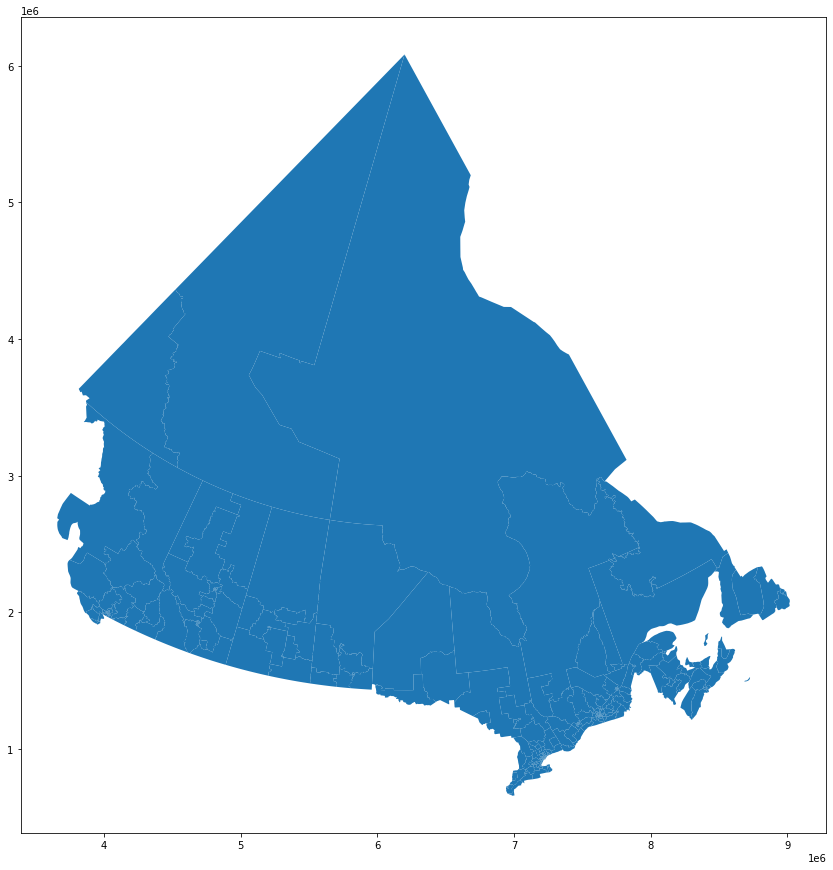

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
Ridings.plot(ax=ax)

<AxesSubplot:>

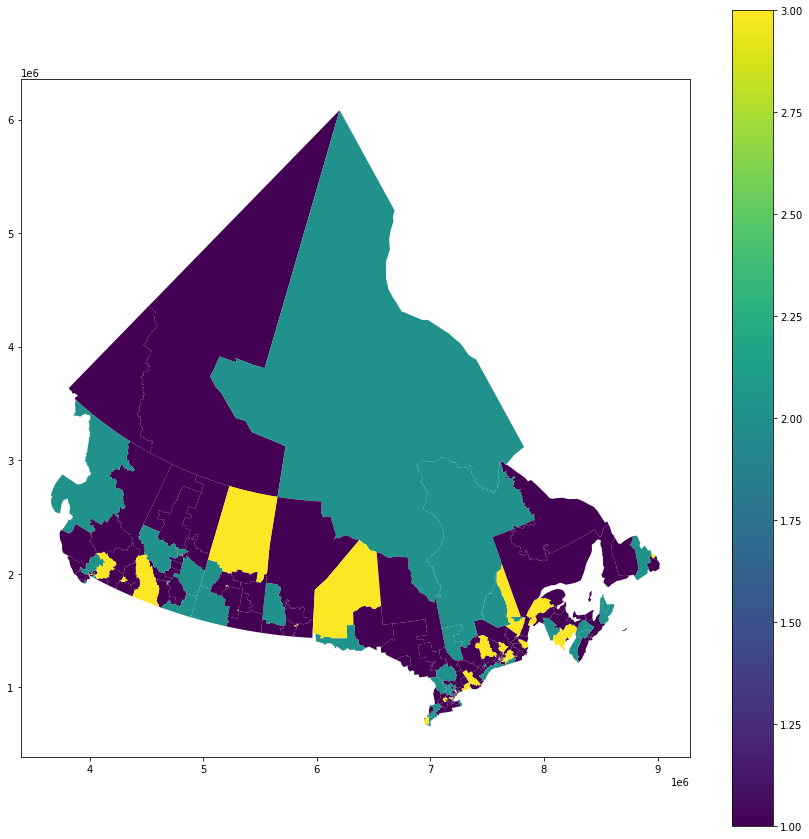

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
map2019.plot(ax=ax, column='Outcome', legend=True, cmap='viridis')


(3390153.7382857143, 9287204.370285716, 387666.3804285715, 6354211.445285714)

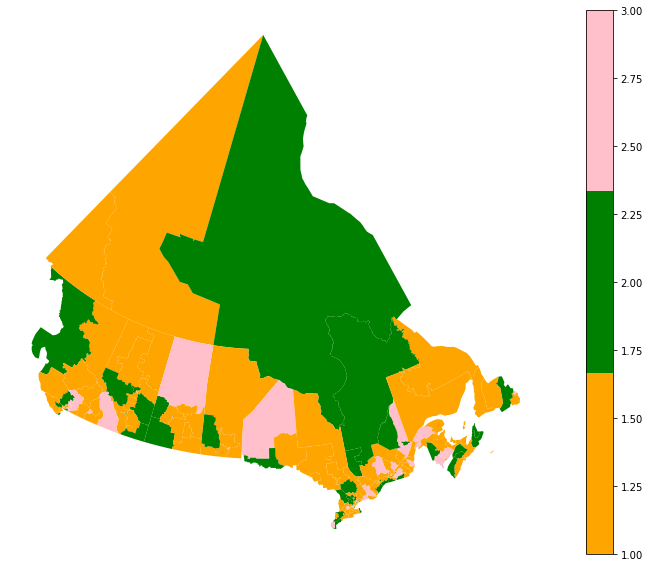

In [52]:
color_dict = {'1':'orange', '2':'green', '3':'pink'}

fig, ax = plt.subplots(figsize=(15,10))
map2019.plot(ax=ax, column="Outcome", legend=True, cmap=colors.ListedColormap(list(color_dict.values())))
gdf.explore(column='Outcome', cmap=colors.ListedColormap(['#D94325','#5CD925']))
plt.axis('off')

(3390153.7382857143, 9287204.370285716, 387666.3804285715, 6354211.445285714)

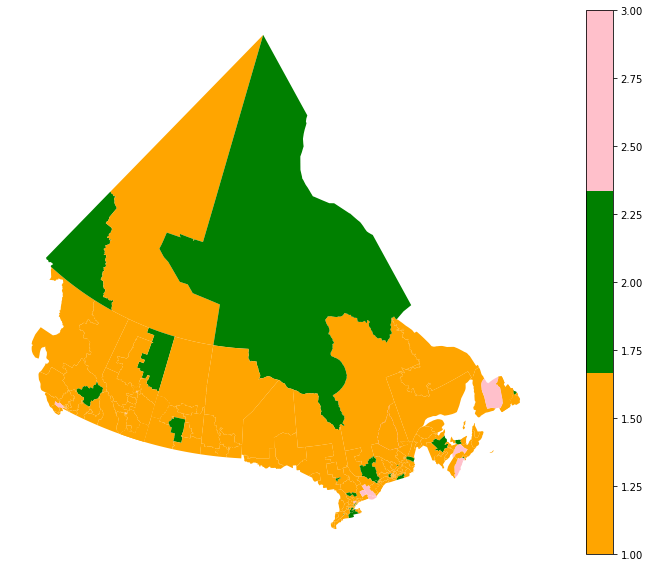

In [54]:
color_dict = {'1':'orange', '2':'green', '3':'pink'}

fig, ax = plt.subplots(figsize=(15,10))
map2021.plot(ax=ax, column="Outcome", legend=True, cmap=colors.ListedColormap(list(color_dict.values())))
plt.axis('off')